In [1]:
%load_ext autoreload
%autoreload 2
import torch, rdkit
import sys, pathlib
from pathlib import Path
PROJECT_ROOT = Path.home()/"바탕화면"/"torch"/"Chem"
sys.path.insert(0, str(PROJECT_ROOT))
from rdkit import Chem
from utils.utils import *

from pathlib import Path
device   = "cuda"
vocab = dataset.vocab
index_to_token = {idx: token for token, idx in vocab.items()}

cuda


{'[#C]': 0, '[#N]': 1, '[*H0]': 2, '[=*H0]': 3, '[=Branch]': 4, '[=C]': 5, '[=N]': 6, '[=O]': 7, '[=S]': 8, '[Branch]': 9, '[C]': 10, '[Cl]': 11, '[EOS]': 12, '[F]': 13, '[NH0+1]': 14, '[N]': 15, '[OH0-1]': 16, '[O]': 17, '[PAD]': 18, '[PH1]': 19, '[P]': 20, '[Ring1]': 21, '[Ring2]': 22, '[SOS]': 23, '[S]': 24, '[SiH0]': 25, '[pop]': 26}
27
tensor([ 2, 10, 17, 10,  2, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18])
tensor([23,  2, 10, 17, 10,  2, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18])
tensor([ 2, 10, 17, 10,  2, 12, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18])


In [2]:
def select_model(choice, latent):
    if choice == "Trans_MHA":
        from models.Trans_MHA import CVAE, PriorNet
        model    = CVAE(latent_dim=latent).cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=latent).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_dmodel256.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_prior.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)

    # Trans
    elif choice == "Trans":
        from models.Trans import CVAE, PriorNet
        model    = CVAE(latent_dim=latent).cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=latent).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_dmodel256_no_mha.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_prior_no_mha.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)
    # LSTM
    elif choice == "LSTM":
        from models.LSTM import CVAE, PriorNet
        model    = CVAE(latent_dim=latent).cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=latent).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM_prior.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)


    # LSTM + MHA
    elif choice == "LSTM_MHA":
        from models.LSTM_MHA import CVAE, PriorNet
        model    = CVAE(latent_dim=latent).cuda().eval()
        model.decoder.cuda().eval()
        prior = PriorNet(y_dim=3, latent_dim=latent).cuda().eval()

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM_MHA.pth")
        state_dict = torch.load(save_path)
        model.load_state_dict(state_dict)

        save_path = (PROJECT_ROOT / "models/weights" / "model_weights_LSTM_MHA_prior.pth")
        state_dict = torch.load(save_path)
        prior.load_state_dict(state_dict)
    

    return model, prior

In [3]:
def select_kernel(choice, model, prior, condition):
    condition = condition.repeat(1024, 1, 1)
    # Trans + MHA
    if choice == "Trans_MHA":
        mean, var = prior(condition.squeeze())
        z = model.reparameterize(mean, var)
        condition = model.input_embedding_p(condition)
        condition = model.pos_enc(condition)
        z_prime = model.ff(model.crossattn(z, condition, condition))

    # Trans
    elif choice == "Trans":
        mean, var = prior(condition.squeeze())
        z_prime = model.reparameterize(mean, var)


    # LSTM
    elif choice == "LSTM":
        mu, lv = prior(condition.squeeze())
        z = model.reparameterize(mu, lv)
        z_prime = z

    # LSTM + MHA
    elif choice == "LSTM_MHA":
        mean, var = prior(condition.squeeze())
        z = model.reparameterize(mean, var)
        condition = model.input_embedding_p(condition)
        z_prime = model.ff(model.crossattn(z, condition, condition))
    
    return z_prime, condition

In [4]:
latent_dim = 128
#condition = torch.tensor([21.0, -0.4, 1.4]).unsqueeze(-1).to(device) 
condition = torch.tensor([0, -0.4, 1.4]).unsqueeze(-1).to(device)
mode = "Trans"
model, prior = select_model(mode, latent_dim)
z_prime, props = select_kernel(mode, model, prior, condition)

# 예시 호출 (z_prime는 shape [1, 265, 64]라고 가정)벡터
if mode =="Trans" or mode =="Trans_MHA":
    generated_tokens = generate_batch_sequence(model, z_prime,
                                        max_length=42, start_token=vocab['[SOS]'],
                                        end_token=vocab['[EOS]'],
                                        pad_token=vocab['[PAD]'], fixed_seq_len=42,
                                        device=device)
elif mode=="LSTM": # LSTM
    generated_tokens = generate_batch_sequence_LSTM(model, z_prime, start_token=9, end_token=10, pad_token=166,
                                                    device=device, grammar_mask_fn=build_grammar_mask,
                                                    index_to_token=index_to_token)
else:
    generated_tokens = generate_batch_sequence_LSTM_MHA(model, z=z_prime, start_token=9, end_token=10, pad_token=166,
                                                        grammar_mask_fn=build_grammar_mask, index_to_token=index_to_token)
print("Generated token sequence:", generated_tokens)

Generated token sequence: [[23, 2, 17, 10, 4, 7, 26, 17, 10, 4, 7, 26, 17, 10, 15, 10, 9, 10, 26, 10, 9, 10, 26, 10, 12], [23, 2, 10, 4, 7, 26, 17, 10, 9, 10, 4, 7, 26, 15, 10, 26, 9, 10, 26, 17, 10, 12], [23, 2, 15, 10, 4, 7, 26, 15, 10, 15, 10, 4, 7, 26, 15, 10, 9, 2, 26, 10, 10, 12], [23, 2, 10, 15, 10, 4, 7, 26, 15, 9, 10, 26, 15, 10, 9, 2, 26, 10, 9, 10, 26, 10, 12], [23, 2, 10, 9, 10, 26, 10, 10, 9, 10, 26, 15, 10, 4, 7, 26, 15, 10, 10, 12], [23, 2, 10, 15, 10, 9, 10, 26, 17, 10, 9, 15, 10, 4, 7, 26, 10, 4, 7, 26, 15, 10, 9, 2, 26, 10, 12], [23, 2, 10, 15, 10, 4, 7, 26, 15, 10, 9, 2, 26, 7, 26, 15, 9, 10, 26, 10, 12], [23, 2, 10, 15, 10, 4, 7, 26, 17, 10, 15, 10, 4, 7, 26, 10, 9, 2, 26, 9, 10, 26, 10, 12], [23, 2, 15, 10, 4, 7, 26, 17, 10, 4, 7, 26, 17, 10, 15, 10, 9, 10, 26, 10, 9, 2, 26, 10, 12], [23, 2, 15, 10, 4, 7, 26, 15, 10, 4, 7, 26, 15, 9, 10, 10, 26, 10, 10, 9, 2, 26, 10, 12], [23, 2, 10, 4, 7, 26, 15, 10, 9, 10, 26, 15, 10, 4, 7, 26, 17, 10, 9, 2, 26, 9, 10, 26, 10, 12

In [12]:
from rdkit import Chem, RDLogger
from rdkit.Chem import DataStructs, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.error')

generated_smiles = []

canbe = 0
notbe = 0
for smi in generated_tokens:
    try:
        del smi[0]
        del smi[-1]
        smiles = tok_ids_to_smiles(smi)
        
        PS(smiles)
        print(PS(smiles).psmiles)
        canbe += 1
        generated_smiles.append(smiles)
    except:
        notbe += 1


print("가능한 분자 개수 :", canbe)
print("불가능한 분자 개수 :", notbe)


[*]NC(=O)NCNC(=O)NC([*])CC
[*]CNC(=O)N(C)NC([*])C(C)C
[*]CNC(C)OCNC(=O)C(=O)NC([*])C
[*]CNC(=O)NC([*])=O
[*]CNC(=O)OCNC(=O)C([*])(C)C
[*]NCOC(=O)OC(=O)NC(C)C([*])C
[*]CC(C)NC(=O)NC(=O)N([*])CC
[*]NC(=O)OC(C)(C)C(=O)NC([*])C
[*]OC(=O)OC=NCNC(=O)C([*])(C)C
[*]CNC(C)OCC(=O)NC([*])C
[*]CNC(=O)CNC(=O)CC([*])CC=C
[*]COC(=O)OC(C)CNC([*])C
[*]C(=O)NC(C)C([*])OCC(=O)C#C
[*]CNC(=O)C(N)OC(C)OC([*])C
[*]NC(=O)OCC(C)C(=O)NC([*])C
[*]NCOC(=O)C([*])=O
[*]CC(C)NC(=O)N([*])C(=O)NC
[*]NC(=O)COC(=O)C([*])C
[*]NC(=O)C(C)OC(=O)OC([*])C
[*]NC(=O)OC(=O)NC([*])(C)CNC
[*]CNCNC(=O)C(=O)C([*])CC
[*]OC(=O)OCC(C([*])C)N(C)C
[*]NC(=O)OC(C)OC([*])CC
[*]NC(=O)NCC(C)C(=O)NC([*])C
[*]CNC(=O)OC([*])OCCNCC(C)C
[*]CNC(=O)OC(=O)OC([*])CC(=O)CC
[*]CNC(=O)OC(C)C(=O)OC([*])C
[*]CNC(=O)NC(=O)C([*])CC
[*]CNCC(=O)NC([*])(C)C=C
[*]CNC(=O)OC(=O)NC([*])C(C)=O
[*]OC(=O)NCC(C)C([*])CC
[*]COC(C=O)C([*])NC(=O)C(N)=O
[*]OC(=O)NCC(C)C(=O)OC([*])C
[*]CNC(=O)OC(C)C(=O)C([*])C=C
[*]C(=O)NC(=O)C([*])C(C)OC
[*]COC(C)NC(=O)NC([*])C
[*]NC(=O)C(

In [13]:
from fcd_torch import FCD
from pathlib import Path

original_smiles = pd.read_csv("/home/kiket/바탕화면/torch/Chem/data/simulation-trajectory-aggregate_aligned.csv").iloc[:,1].values
calc       = FCD(device=device, n_jobs=8)

fcd_score  = calc(generated_smiles, original_smiles)
print(f"FCD = {fcd_score:.3f}")


FCD = 5.880


(array([4.000e+00, 1.900e+01, 4.800e+01, 1.780e+02, 5.170e+02, 1.383e+03,
        2.802e+03, 1.263e+03, 5.400e+01, 2.000e+00]),
 array([-5.93675404, -4.97875974, -4.02076543, -3.06277113, -2.10477682,
        -1.14678252, -0.18878821,  0.76920609,  1.72720039,  2.6851947 ,
         3.643189  ]),
 <BarContainer object of 10 artists>)

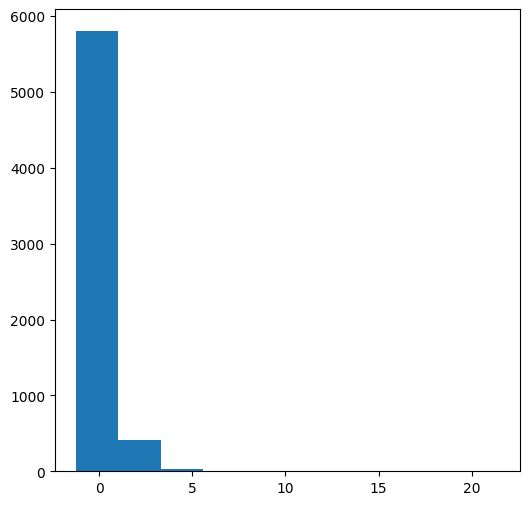

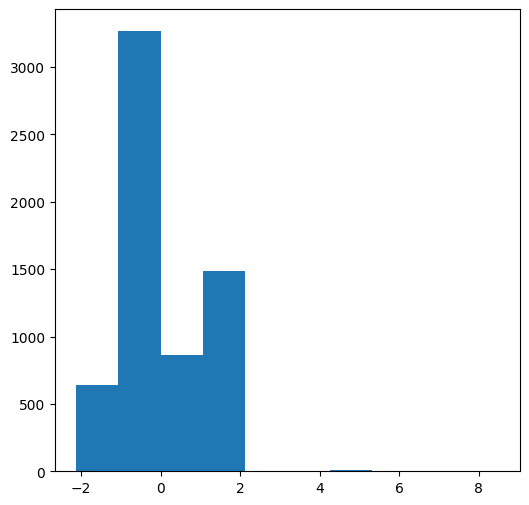

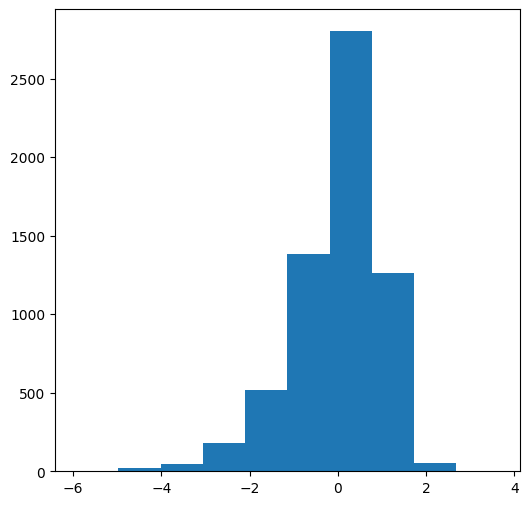

In [7]:
raw = pd.read_csv("/home/kiket/바탕화면/torch/Chem/data/simulation-trajectory-aggregate_aligned.csv")
#Li-ion Conductivity
conductivity = raw.iloc[:, 6:7].values
conductivity = mm_scaler.fit_transform(conductivity.reshape(-1, 1))
conductivity = log_minmax_pipeline.fit_transform(conductivity.reshape(-1, 1))

#Degree of Polymerization
DP = raw.iloc[:, 4:5].values
DP = mm_scaler.fit_transform(DP.reshape(-1, 1))

#Transfer Number
tn = raw.iloc[:, 10:11].values
tn = mm_scaler.fit_transform(tn.reshape(-1, 1))

properties = np.concat((conductivity, DP, tn), axis=-1)
mean_vec = properties.mean(axis=0)
std_vec  = properties.std(axis=0)
properties = (properties - mean_vec) / std_vec  # 정규화된 3차원 조건 벡터

plt.figure(figsize=(6,6))
plt.hist(properties[:,0])
plt.figure(figsize=(6,6))
plt.hist(properties[:,1])
plt.figure(figsize=(6,6))
plt.hist(properties[:,2])